(50000, 154)
Baseline Fit time: 0.03033871650695801
Baseline MAE: 0.7151806920839866
LinReg Fit time: 0.890366506576538
LinReg MAE: 0.7081865402787184
MAE Ratio: 0.009779559043865849
KNN regressor MAE: 0.7100230508996894
MAE Ratio: 0.007211661670099345
Part 2
Means: [np.float64(-0.7076812855655203), np.float64(-0.7080470299596706), np.float64(-0.7081695657288474), np.float64(-0.7081847660218401), np.float64(-0.7081863626802601), np.float64(-0.7081865225177945)]
Std errors: [np.float64(0.0670781591565054), np.float64(0.06707796307506932), np.float64(0.06709182404497827), np.float64(0.06709308304801793), np.float64(0.06709319413949454), np.float64(0.06709320542934832)]
Ridge Fit time: 0.14936842918395996
Ridge MAE: 0.7080470299596706
MAE Ratio: 0.009974629073848496


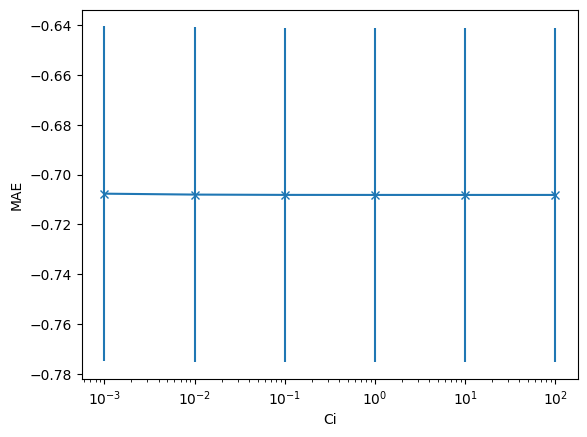

In [1]:
import os
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


def mae_ratio(mae, baseline_mae):
    return 1 - (mae / baseline_mae)

def gaussian_kernel(dist):
    weights = np.exp(-g * (dist ** 2))
    return weights / np.sum(weights)


GAMES_LIMIT = 50000  # Updated based on the file name
MOVES_LIMIT = 50     # Matches your X file naming convention
CV = 5
g = 0.00001

DATA_DIR_X = "data/x/piece_pos_advantage"
DATA_DIR_Y = "data/y"


def main():
    from sklearn.dummy import DummyRegressor

    # File paths
    x_file = f"{DATA_DIR_X}/{GAMES_LIMIT // 1000}k_{MOVES_LIMIT}.csv"
    y_file = f"{DATA_DIR_Y}/y_{GAMES_LIMIT // 1000}k.csv"

    # Ensure files exist
    if not os.path.exists(x_file):
        raise FileNotFoundError(f"X file not found: {x_file}")
    if not os.path.exists(y_file):
        raise FileNotFoundError(f"Y file not found: {y_file}")

    # Load data
    X = np.genfromtxt(x_file, dtype=float, delimiter=',', names=None)
    y = np.genfromtxt(y_file, dtype=int, delimiter=',', names=None)

    # Preprocessing
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y.reshape(-1, 1)).flatten()
    X = PolynomialFeatures(1).fit_transform(X)

    print(X.shape)
    # Baseline model
    baseline = DummyRegressor()
    cv_results = cross_validate(
        baseline, X, y, cv=CV, scoring='neg_mean_absolute_error'
    )
    baseline_fit_time = np.mean(cv_results['fit_time'])
    print(f'Baseline Fit time: {baseline_fit_time}')
    baseline_mae = -np.mean(cv_results['test_score'])
    print(f'Baseline MAE: {baseline_mae}')

    # Linear Regression
    lr_model = LinearRegression()
    cv_results = cross_validate(
        lr_model, X, y, cv=CV, scoring='neg_mean_absolute_error'
    )
    lr_fit_time = np.mean(cv_results['fit_time'])
    print(f'LinReg Fit time: {lr_fit_time}')
    lr_mae = -np.mean(cv_results['test_score'])
    print(f'LinReg MAE: {lr_mae}')
    print(f'MAE Ratio: {mae_ratio(lr_mae, baseline_mae)}')

    # KNN Regression
    knn_model = KNeighborsRegressor(n_neighbors=8000, weights=gaussian_kernel, metric='euclidean')
    cv_results = cross_validate(knn_model, X, y, cv=CV, scoring='neg_mean_absolute_error')
    knn_fit_time = np.mean(cv_results['fit_time'])
    knn_mae = -np.mean(cv_results['test_score'])
    print(f'KNN regressor MAE: {knn_mae}')
    print(f'MAE Ratio: {mae_ratio(knn_mae, baseline_mae)}')

    # Ridge Regression with varying alpha
    plt.figure()
    C_vals = [0.001, 0.01, 0.1, 1, 10, 100]
    means = []
    stds = []

    for Ci in C_vals:
        model = Ridge(alpha=1 / Ci, max_iter=10000)
        kf = KFold(n_splits=CV)
        predictions = []

        for train, test in kf.split(X):
            model.fit(X[train], y[train])
            ypred = model.predict(X[test])
            error = -mean_absolute_error(y[test], ypred)
            predictions.append(error)

        means.append(np.mean(predictions))
        stds.append(np.std(predictions))

    print("Part 2")
    print(f"Means: {means}")
    print(f"Std errors: {stds}")

    plt.errorbar(np.array(C_vals), np.array(means), np.array(stds), linestyle=None,
                 marker='x', capsize=0)
    plt.xlabel("Ci")
    plt.ylabel("MAE")
    plt.xscale("log")

    ridge_model = Ridge(alpha=1 / 0.01, max_iter=10000)
    cv_results = cross_validate(
        ridge_model, X, y, cv=CV, scoring='neg_mean_absolute_error'
    )
    ridge_fit_time = np.mean(cv_results['fit_time'])
    print(f'Ridge Fit time: {ridge_fit_time}')
    ridge_mae = -np.mean(cv_results['test_score'])
    print(f'Ridge MAE: {ridge_mae}')
    print(f'MAE Ratio: {mae_ratio(ridge_mae, baseline_mae)}')

    plt.show()


if __name__ == "__main__":
    main()